In [1]:
# Import Packages
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tensorflow as tf
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import optimizers

#Resize the image to 96*96
IMG_WIDTH = 96
IMG_HEIGHT = 96
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
#Get ID
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
    
# Get test images and masks
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [03:22<00:00,  9.54it/s]


Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 70.12it/s]


Done!


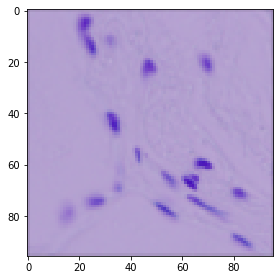

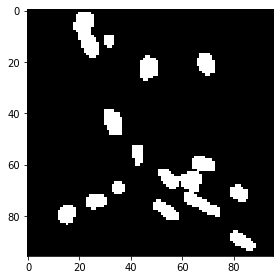

In [4]:
#Check train image and train mask
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [5]:
#Define Intersection over Union (IoU)
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)        
        if true == 0:
            metric += (pred == 0)
            continue
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union        
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10        
        metric += iou        
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    return tf.compat.v1.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [6]:
#Build and train our neural network
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.2) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.2) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.2) (c9)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[my_iou_metric], lr = 3e-4)
model.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
_______________

In [7]:
#Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('Unet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
592/603 [============================>.] - ETA: 2:44 - loss: 0.7416 - my_iou_metric: 0.0000e+0 - ETA: 52s - loss: 0.7144 - my_iou_metric: 0.0000e+0 - ETA: 30s - loss: 0.7438 - my_iou_metric: 0.0000e+ - ETA: 20s - loss: 0.7111 - my_iou_metric: 0.0027   - ETA: 15s - loss: 0.6708 - my_iou_metric: 0.00 - ETA: 11s - loss: 0.6684 - my_iou_metric: 0.00 - ETA: 9s - loss: 0.6434 - my_iou_metric: 0.0014 - ETA: 7s - loss: 0.6167 - my_iou_metric: 0.002 - ETA: 6s - loss: 0.5907 - my_iou_metric: 0.002 - ETA: 5s - loss: 0.5738 - my_iou_metric: 0.014 - ETA: 4s - loss: 0.5562 - my_iou_metric: 0.029 - ETA: 3s - loss: 0.5390 - my_iou_metric: 0.050 - ETA: 2s - loss: 0.5177 - my_iou_metric: 0.070 - ETA: 2s - loss: 0.5013 - my_iou_metric: 0.084 - ETA: 1s - loss: 0.4839 - my_iou_metric: 0.103 - ETA: 1s - loss: 0.4714 - my_iou_metric: 0.114 - ETA: 0s - loss: 0.

Epoch 14/100
592/603 [============================>.] - ETA: 1s - loss: 0.1001 - my_iou_metric: 0.687 - ETA: 1s - loss: 0.1050 - my_iou_metric: 0.708 - ETA: 1s - loss: 0.0990 - my_iou_metric: 0.706 - ETA: 1s - loss: 0.0928 - my_iou_metric: 0.717 - ETA: 1s - loss: 0.0893 - my_iou_metric: 0.720 - ETA: 1s - loss: 0.0894 - my_iou_metric: 0.734 - ETA: 0s - loss: 0.0903 - my_iou_metric: 0.734 - ETA: 0s - loss: 0.0906 - my_iou_metric: 0.730 - ETA: 0s - loss: 0.0911 - my_iou_metric: 0.736 - ETA: 0s - loss: 0.0907 - my_iou_metric: 0.740 - ETA: 0s - loss: 0.0888 - my_iou_metric: 0.743 - ETA: 0s - loss: 0.0902 - my_iou_metric: 0.742 - ETA: 0s - loss: 0.0893 - my_iou_metric: 0.745 - ETA: 0s - loss: 0.0903 - my_iou_metric: 0.745 - ETA: 0s - loss: 0.0916 - my_iou_metric: 0.740 - ETA: 0s - loss: 0.0924 - my_iou_metric: 0.741 - ETA: 0s - loss: 0.0936 - my_iou_metric: 0.736 - ETA: 0s - loss: 0.0953 - my_iou_metric: 0.736 - ETA: 0s - loss: 0.0945 - my_iou_metric: 0.7351
Epoch 00014: val_loss did not imp

Epoch 21/100
592/603 [============================>.] - ETA: 1s - loss: 0.0618 - my_iou_metric: 0.793 - ETA: 1s - loss: 0.0765 - my_iou_metric: 0.758 - ETA: 1s - loss: 0.0801 - my_iou_metric: 0.771 - ETA: 1s - loss: 0.0808 - my_iou_metric: 0.774 - ETA: 1s - loss: 0.0783 - my_iou_metric: 0.779 - ETA: 1s - loss: 0.0774 - my_iou_metric: 0.784 - ETA: 0s - loss: 0.0754 - my_iou_metric: 0.783 - ETA: 0s - loss: 0.0818 - my_iou_metric: 0.778 - ETA: 0s - loss: 0.0821 - my_iou_metric: 0.776 - ETA: 0s - loss: 0.0817 - my_iou_metric: 0.777 - ETA: 0s - loss: 0.0805 - my_iou_metric: 0.774 - ETA: 0s - loss: 0.0802 - my_iou_metric: 0.776 - ETA: 0s - loss: 0.0798 - my_iou_metric: 0.778 - ETA: 0s - loss: 0.0808 - my_iou_metric: 0.775 - ETA: 0s - loss: 0.0821 - my_iou_metric: 0.769 - ETA: 0s - loss: 0.0821 - my_iou_metric: 0.767 - ETA: 0s - loss: 0.0828 - my_iou_metric: 0.764 - ETA: 0s - loss: 0.0838 - my_iou_metric: 0.762 - ETA: 0s - loss: 0.0829 - my_iou_metric: 0.7623
Epoch 00021: val_loss did not imp

Epoch 28/100
592/603 [============================>.] - ETA: 1s - loss: 0.0744 - my_iou_metric: 0.800 - ETA: 1s - loss: 0.0851 - my_iou_metric: 0.781 - ETA: 1s - loss: 0.0805 - my_iou_metric: 0.795 - ETA: 1s - loss: 0.0800 - my_iou_metric: 0.778 - ETA: 1s - loss: 0.0812 - my_iou_metric: 0.770 - ETA: 1s - loss: 0.0767 - my_iou_metric: 0.772 - ETA: 0s - loss: 0.0768 - my_iou_metric: 0.774 - ETA: 0s - loss: 0.0773 - my_iou_metric: 0.779 - ETA: 0s - loss: 0.0767 - my_iou_metric: 0.782 - ETA: 0s - loss: 0.0756 - my_iou_metric: 0.786 - ETA: 0s - loss: 0.0757 - my_iou_metric: 0.783 - ETA: 0s - loss: 0.0787 - my_iou_metric: 0.780 - ETA: 0s - loss: 0.0800 - my_iou_metric: 0.778 - ETA: 0s - loss: 0.0788 - my_iou_metric: 0.779 - ETA: 0s - loss: 0.0781 - my_iou_metric: 0.781 - ETA: 0s - loss: 0.0771 - my_iou_metric: 0.783 - ETA: 0s - loss: 0.0782 - my_iou_metric: 0.782 - ETA: 0s - loss: 0.0775 - my_iou_metric: 0.782 - ETA: 0s - loss: 0.0772 - my_iou_metric: 0.7797
Epoch 00028: val_loss did not imp

Epoch 42/100
592/603 [============================>.] - ETA: 1s - loss: 0.0645 - my_iou_metric: 0.787 - ETA: 1s - loss: 0.0710 - my_iou_metric: 0.781 - ETA: 1s - loss: 0.0651 - my_iou_metric: 0.800 - ETA: 1s - loss: 0.0634 - my_iou_metric: 0.797 - ETA: 1s - loss: 0.0629 - my_iou_metric: 0.795 - ETA: 1s - loss: 0.0619 - my_iou_metric: 0.804 - ETA: 0s - loss: 0.0649 - my_iou_metric: 0.805 - ETA: 0s - loss: 0.0645 - my_iou_metric: 0.809 - ETA: 0s - loss: 0.0636 - my_iou_metric: 0.809 - ETA: 0s - loss: 0.0636 - my_iou_metric: 0.812 - ETA: 0s - loss: 0.0636 - my_iou_metric: 0.815 - ETA: 0s - loss: 0.0635 - my_iou_metric: 0.815 - ETA: 0s - loss: 0.0637 - my_iou_metric: 0.815 - ETA: 0s - loss: 0.0645 - my_iou_metric: 0.811 - ETA: 0s - loss: 0.0633 - my_iou_metric: 0.813 - ETA: 0s - loss: 0.0639 - my_iou_metric: 0.813 - ETA: 0s - loss: 0.0634 - my_iou_metric: 0.813 - ETA: 0s - loss: 0.0635 - my_iou_metric: 0.815 - ETA: 0s - loss: 0.0635 - my_iou_metric: 0.8137
Epoch 00042: val_loss did not imp

In [8]:
# Predict on train, validation and test
model = load_model('Unet.h5', custom_objects={'my_iou_metric': my_iou_metric})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

603/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 2s 3ms/sample
67/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

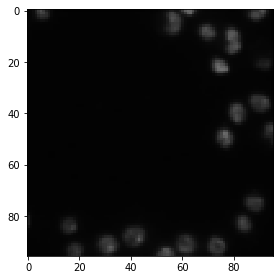

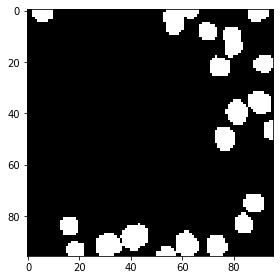

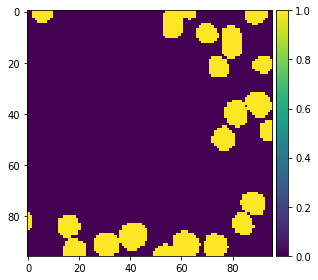

In [9]:
#Check train
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

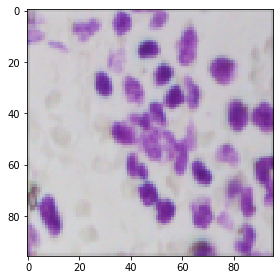

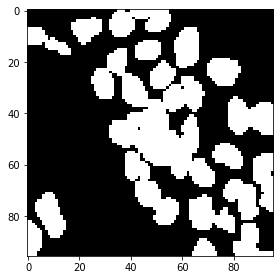

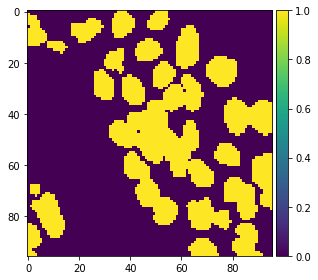

In [10]:
#Check validation
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()